In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
print(os.listdir("C:\\Users\\hanse\\Downloads\\uts deep learning\\train"))

['hotdog', 'not_hotdog']


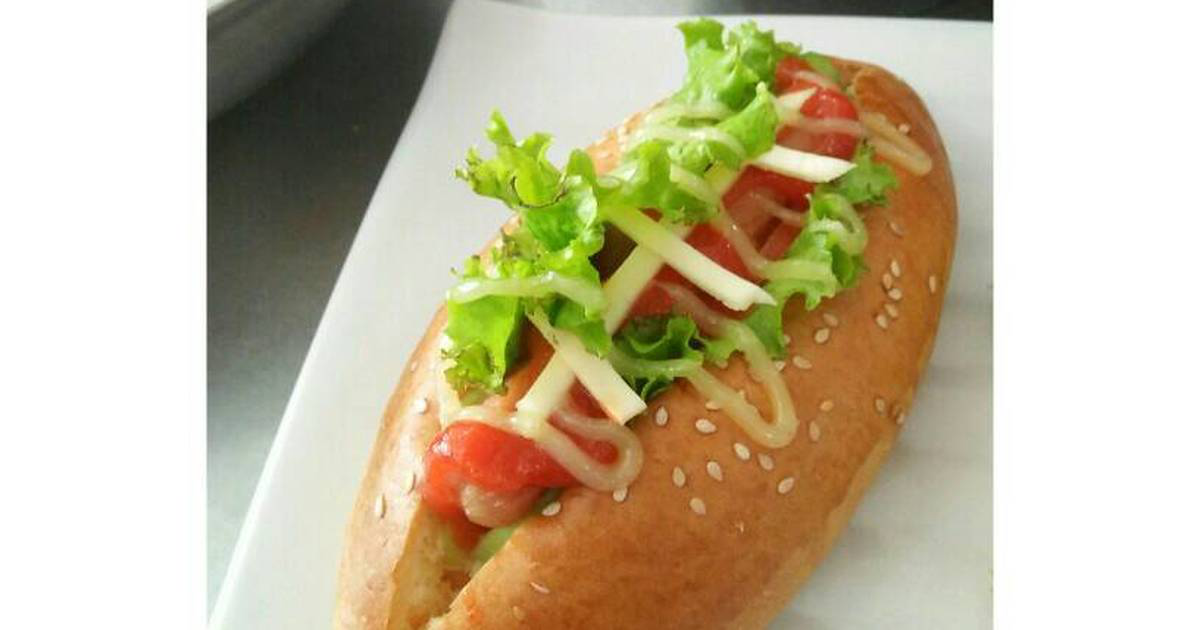

In [2]:
from PIL import Image
data_dir = "C:\\Users\\hanse\\Downloads\\uts deep learning\\"
path = data_dir + "train\\hotdog\\4.photo.jpg"
Image.open(path)

In [3]:
import Helper
import torch
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.RandomResizedCrop(224),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])
test_transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

train_data = datasets.ImageFolder(data_dir+"\\train", transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,shuffle=True)

test_data = datasets.ImageFolder(data_dir+"\\test", transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

print(len(train_loader))
print(len(test_loader))

2
2


In [4]:
classes = os.listdir(data_dir+"\\train")
classes

['hotdog', 'not_hotdog']

C:\Users\hanse\anaconda3\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


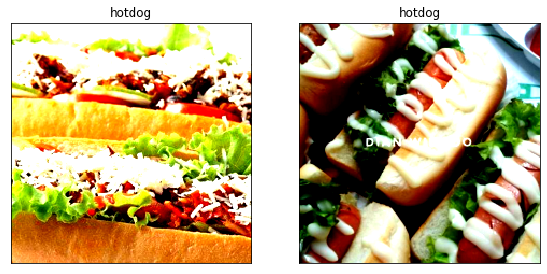

In [5]:
Helper.visualize(test_loader, classes)

In [6]:
model = models.densenet161(pretrained=True)
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [7]:
model = Helper.freeze_parameters(model)

In [8]:
import torch.nn as nn
from collections import OrderedDict

classifier = nn.Sequential(
  nn.Linear(in_features=2208, out_features=2208),
  nn.ReLU(),
  nn.Dropout(p=0.4),
  nn.Linear(in_features=2208, out_features=1024),
  nn.ReLU(),
  nn.Dropout(p=0.3),
  nn.Linear(in_features=1024, out_features=8),
  nn.LogSoftmax(dim=1)  
)
    
model.classifier = classifier
model.classifier

Sequential(
  (0): Linear(in_features=2208, out_features=2208, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=2208, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=1024, out_features=8, bias=True)
  (7): LogSoftmax(dim=1)
)

In [16]:
import torch.optim as optim
import torch

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(dev)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

In [17]:
epoch = 5+5

In [18]:
model, train_loss, test_loss = Helper.train(model, train_loader, test_loader, epoch, optimizer, criterion)

Epoch: 1/10
		Going for validation
	Train loss:1.874929.. 	Valid Loss:19.764091.. 	Accuracy: 51.5152
	Validation loss decreased (inf --> 19.764091).  Saving model ...
	Epoch:1 completed in 0m 9s
Epoch: 2/10
		Going for validation
	Train loss:16.459330.. 	Valid Loss:1.383239.. 	Accuracy: 51.5152
	Validation loss decreased (19.764091 --> 1.383239).  Saving model ...
	Epoch:2 completed in 0m 8s
Epoch: 3/10
		Going for validation
	Train loss:1.338668.. 	Valid Loss:0.973611.. 	Accuracy: 48.4848
	Validation loss decreased (1.383239 --> 0.973611).  Saving model ...
	Epoch:3 completed in 0m 9s
Epoch: 4/10
		Going for validation
	Train loss:0.911740.. 	Valid Loss:0.487013.. 	Accuracy: 100.0000
	Validation loss decreased (0.973611 --> 0.487013).  Saving model ...
	Epoch:4 completed in 0m 9s
Epoch: 5/10
		Going for validation
	Train loss:0.548754.. 	Valid Loss:0.367887.. 	Accuracy: 96.9697
	Validation loss decreased (0.487013 --> 0.367887).  Saving model ...
	Epoch:5 completed in 0m 9s
Epoch: 6/1

In [19]:
model = Helper.load_latest_model(model)

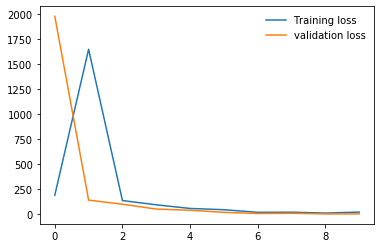

In [20]:
Helper.check_overfitted(train_loss, test_loss)

# testing

In [32]:
def test(model, loader, criterion=None):
    """
    Helper function for test result. This function use torch.mean()
    :param model: current result
    :param loader: test data loader
    :param criterion: loss function to track loss, default None
    :return: None
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_loss = 0
    accuracy = 0

    with torch.no_grad():
        model.eval()

        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)

            if criterion is not None:
                batch_loss = criterion(logps, labels)
                test_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    if criterion is not None:
        print("Test Loss:{:.6f}".format(test_loss),
              "\nAccuracy: {:.4f}".format(accuracy / len(loader) * 100))
    else:
        print("Accuracy: {:.4f}".format(accuracy / len(loader) * 100))

test(model, test_loader)

Accuracy: 100.0000


In [31]:
from PIL import Image
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
def test(file):
  ids = train_loader.dataset.class_to_idx

  with Image.open(file) as f:
      img = test_transform(f).unsqueeze(0)
      with torch.no_grad():
          out = model(img.to(device)).cpu().numpy()
          for key, value in ids.items():
              if value == np.argmax(out):
                    #name = classes[int(key)]
                    print(f"Predicted Label: {key} and value {value}")
          plt.imshow(np.array(f))
          plt.show()


C:\Users\hanse\Downloads\uts deep learning\\test\hotdog\87.hotdog-1516269816673-x.jpeg
Predicted Label: hotdog and value 0


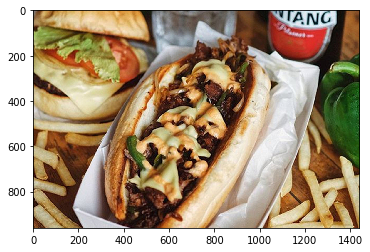

In [23]:
from PIL import Image
from matplotlib import pyplot as plt
name = os.listdir(data_dir+"\\test\\hotdog")[6]
file = data_dir+'\\test\\hotdog\\'+name
print(file)

test(file)

C:\Users\hanse\Downloads\uts deep learning\\test\not_hotdog\87.award-winning-pizza-catering-sq-c.jpg
Predicted Label: not_hotdog and value 1


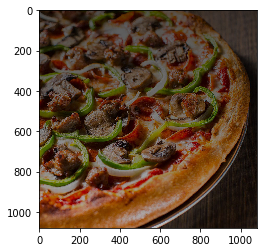

In [24]:
name = os.listdir(data_dir+"\\test\\not_hotdog")[6]
file = data_dir+'\\test\\not_hotdog\\'+name
print(file)

test(file)